# Soil organic carbon based on LUCAS topsoil

## The calculation of soil organic carbon:

The data from Lucas will now be used to first calculate the soil organic stock and then the flux using the following formula:

SOC-stock (tC/ha) = SOC (g C/kg soil)  BD  depth (cm) * stones [1-(%rock volume/100)]
---------------------------------------------------------------------------------------------
The required data such as SOC, BD, depth and stones are not available for each LUCAS survey. In addition, the number of soil samples is not very high and therefore not representative for larger reference units.

Therefore, we want to use the following method:

For each NUTS2 region, a mean BD and stone (coarse fragment) share will be calculated over all years (2009/12, 2015, and 2018) (max, min, range,...) for 20cm depth and LULUCF category. The topsoil 2018 data will be classified according to the LULUCF classes (each point's LC code is translated into its respective LULUCF category based on a look-up table). For each point, the average OC concentration by NUTS-2 and LULUCF cateegory is calculated from the 2018 database only. Now, the formula can be applied as all information is available.


##  The calculations presented here must be started on the CWS of the EEA. In addition, access to the SQL database Carbon_Mapping on the server "Greenmonkey" is necessary.


Example: count of lucas 2018 points with OC information:

In [100]:
import pyodbc 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy as sa
from sqlalchemy import create_engine, event
from sqlalchemy.engine.url import URL

        

print ("connect to engine......")
engine = sa.create_engine('mssql+pyodbc://' + "GREENMONKEY" + '/' + "Carbon_Mapping" + '?trusted_connection=yes&driver=ODBC+Driver+13+for+SQL+Server')

print ("connection to greenmonkey found")
print ("Reading LUCAS topsoil 2018 data from greenmonkey and calc. number of points, min, avg and max OC2018 for every NUTS2 region in Austria:")
query=('''

SELECT  [LEVEL2_COD_v2021]
		,[LULUCF_CODE]
		,[LULUCF_DESCRIPTION]  
		,count([POINTID]) as count_points
		,min([OC]) as min_OC
		,max([OC]) as max_OC
		,avg([OC]) as min_OC
  FROM [Carbon_Mapping].[lucas].[lucas_topsoil_2018_v2021]
  join [LUT].[LUCAS_landcover_into_LULUCF_classification] on [LUCAS_landcover_into_LULUCF_classification].[LUCAS Level2] = [lucas_topsoil_2018_v2021].LC
  where left(LEVEL2_COD_v2021,2)='AT'
  group by 
  [LEVEL2_COD_v2021], [LULUCF_CODE] ,[LULUCF_DESCRIPTION] order by [LEVEL2_COD_v2021], [LULUCF_DESCRIPTION]
''')  
df_oc2018_nuts2_stat_AT = pd.read_sql(query, engine)
print(df_oc2018_nuts2_stat_AT.head(26))
#pivot 

print ("end....")

connect to engine......
connection to greenmonkey found
Reading LUCAS topsoil 2018 data from greenmonkey and calc. number of points, min, avg and max OC2018 for every NUTS2 region in Austria:
   LEVEL2_COD_v2021 LULUCF_CODE LULUCF_DESCRIPTION  count_points  min_OC  \
0              AT12          FL        Forest land             9    15.4   
1              AT12          GL          Grassland            15    14.6   
2              AT12          OL         Other land             1    21.0   
3              AT12          SL        Settlements             1    19.3   
4              AT21          FL        Forest land             2    26.8   
5              AT21          GL          Grassland            17    13.1   
6              AT22          FL        Forest land             5    23.1   
7              AT22          GL          Grassland            45    12.2   
8              AT31          FL        Forest land             4    37.5   
9              AT31          GL          Grassla

In [102]:
## Importing data from MS-SQL into pyhton:
query=('''
SELECT  [POINTID]
      ,[Depth]
      ,[pH_CaCl2]
      ,[pH_H2O]
      ,[EC]
      ,[OC]
      ,[CaCO3]
      ,[P]
      ,[N]
      ,[K]
      ,[OC (20-30 cm)]
      ,[CaCO3 (20-30 cm)]
      ,[Ox_Al]
      ,[Ox_Fe]
      ,[SURVEY_DATE]
      ,[LC]
      ,[LU]
      ,[LC0_Desc]
      ,[LC1_Desc]
      ,[LU1_Desc]
      ,[TH_LONG]
      ,[TH_LAT]
      ,[Elev]
      ,[LEVEL0_COD_v2021]
      ,[LEVEL1_COD_v2021]
      ,[LEVEL2_COD_v2021]
      ,[LEVEL3_COD_v2021]
      ,[LEVEL0_NAM]
      ,[LEVEL1_NAM]
      ,[LEVEL2_NAM]
      ,[LEVEL3_NAM]
      ,[TAA]
      ,[NUTS_EU]
		,[LULUCF_CODE]
		,[LULUCF_DESCRIPTION]  
  FROM [Carbon_Mapping].[lucas].lucas_topsoil_2018_v2021
  join [LUT].[LUCAS_landcover_into_LULUCF_classification] on [LUCAS_landcover_into_LULUCF_classification].[LUCAS Level2] = lucas_topsoil_2018_v2021.LC
 

''')  
df_oc2018_nuts2 = pd.read_sql(query, engine)
#pivot 
print ("done")

done


<AxesSubplot:title={'center':'OC'}, xlabel='LEVEL0_COD_v2021'>

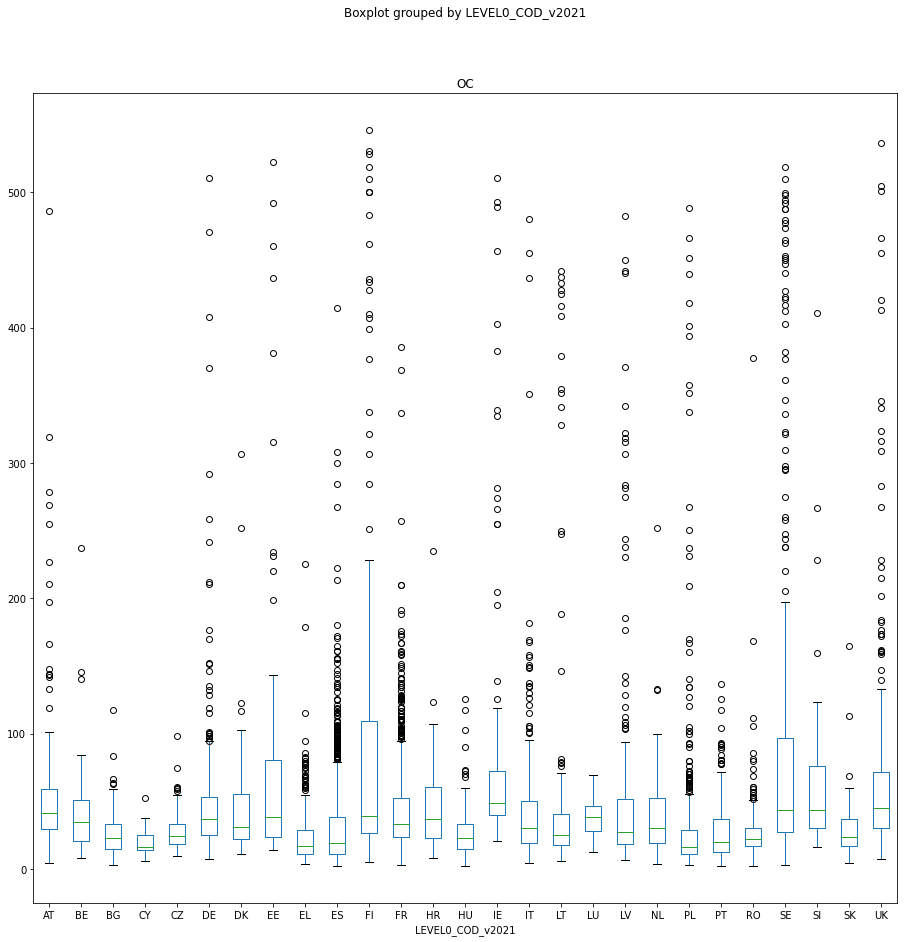

In [103]:
## Box plot OC- statistics by nuts2
df_oc2018_nuts2.head()

df_oc2018_nuts2.boxplot(by ='LEVEL0_COD_v2021', column =['OC'], grid = False, figsize=(15, 15))

#df_oc2018_nuts2.boxplot(by ='NUTS_2', column =['OC'], grid = FALSE)

# --------------Calculation---------------------------------------------------------------

## (1.1) For every NUTS2 area (NUTS2021) - calculation Bulk Density (BD)

In [73]:
# Bulk density (BD) 2018

engine = sa.create_engine('mssql+pyodbc://' + "GREENMONKEY" + '/' + "Carbon_Mapping" + '?trusted_connection=yes&driver=ODBC+Driver+13+for+SQL+Server')
connection = engine.raw_connection()
cursor = connection.cursor()


query1 =( '''
SELECT [BulkDensity_2018].[POINT_ID]
      ,[BD 0-10]
      ,[BD 10-20]
      ,[BD 20-30]
      ,[BD 0-20]
	,[LEVEL2_COD]

  FROM [Carbon_Mapping].[lucas].[BulkDensity_2018]
  left join [lucas].[lucas_grid_with_admin_2021_information_v2023_1]
     on [BulkDensity_2018].[POINT_ID] = [lucas_grid_with_admin_2021_information_v2023_1].[POINT_ID]

''')
df_bulk_density_2018 = pd.read_sql(query1, engine)
#----------------------------------------------------------------------------------------------------
## drop table if exists:
sql_query1=( '''Drop table if exists [Carbon_Mapping].[lucas].[BulkDensity_2018_nuts2]''')
cursor.execute(sql_query1)
#cursor.close()
#connection.commit()


sql_query2 =( '''
/****** Script calculation min, max, avg bulk density 2018 for nuts2 (version 2021) ******/
SELECT [LEVEL2_COD]
 	 ,count([LEVEL2_COD]) as count_points
      ,max([BD 0-10]) as [BD 0-10 max]
	  ,max([BD 0-20]) as [BD 0-20 max]
      ,max([BD 10-20]) as [BD 10-20 max]     
	  ,max([BD 20-30]) as [BD 20-30 max]

	  ,min([BD 0-10]) as [BD 0-10 min]
	  ,min([BD 0-20]) as [BD 0-20 min]
      ,min([BD 10-20]) as [BD 10-20 min]     
	  ,min([BD 20-30]) as [BD 20-30 min]

	  ,avg([BD 0-10]) as [BD 0-10 avg]
	  ,avg([BD 0-20]) as [BD 0-20 avg]
      ,avg([BD 10-20]) as [BD 10-20 avg]     
	  ,avg([BD 20-30]) as [BD 20-30 avg]

into  [Carbon_Mapping].[lucas].[BulkDensity_2018_nuts2]
  FROM [Carbon_Mapping].[lucas].[BulkDensity_2018]
  left join [lucas].[lucas_grid_with_admin_2021_information_v2023_1]
     on [BulkDensity_2018].[POINT_ID] = [lucas_grid_with_admin_2021_information_v2023_1].[POINT_ID]
group by [LEVEL2_COD]
''')
cursor.execute(sql_query2)
cursor.close()
connection.commit()


query3 =('''Select * from [Carbon_Mapping].[lucas].[BulkDensity_2018_nuts2]''')
df_bulk_density_2018_nuts2_stats = pd.read_sql(query3, engine)

print ("Done")

Done


### The following box shows the bulk density 2018 statistic for the NUTS2 region FRJ1 :

In [98]:
#df_example_nuts3_bd18 = [df_bulk_density_2018_nuts2_stats['LEVEL2_COD'] =='FRJ1']
df2=df_bulk_density_2018_nuts2_stats[df_bulk_density_2018_nuts2_stats["LEVEL2_COD"] == 'FRJ1'] 
df2

,LEVEL2_COD,count_points,BD 0-10 max,BD 0-20 max,BD 10-20 max,BD 20-30 max,BD 0-10 min,BD 0-20 min,BD 10-20 min,BD 20-30 min,BD 0-10 avg,BD 0-20 avg,BD 10-20 avg,BD 20-30 avg
2,FRJ1,36,2.436,2.574,2.713,NaN,0.168,0.174,0.181,NaN,1.023222,1.123939,1.186394,NaN



## (1.2) For every NUTS2 area (NUTS2021) - calculation of OC soil-depth based ond Lucas topsoil 2018:


In [105]:
# OC at depth, Nuts3 and LULUCF class 2018

engine = sa.create_engine('mssql+pyodbc://' + "GREENMONKEY" + '/' + "Carbon_Mapping" + '?trusted_connection=yes&driver=ODBC+Driver+13+for+SQL+Server')
connection = engine.raw_connection()
cursor = connection.cursor()

## drop table if exists:
sql_query5=( '''Drop table if exists [Carbon_Mapping].[lucas].[OC_2018_nuts2]''')
cursor.execute(sql_query5)
#cursor.close()
#connection.commit()
#----------------------------------------------------------------------------
query6 =('''
SELECT  
      [LEVEL2_COD_v2021]  
	  ,[Depth]
		,[LULUCF_CODE]
		,[LULUCF_DESCRIPTION]  
		,count([POINTID]) as count_points
		,min([OC]) as OC_min
		,max([OC]) as OC_max
	    ,avg([OC]) as OC_avg
		,'Organic carbon content (at depth 0-20cm) in [g/kg]' as OC_UNIT

into  [Carbon_Mapping].[lucas].OC_2018_nuts2
  FROM [Carbon_Mapping].[lucas].lucas_topsoil_2018_v2021
  left join [LUT].[LUCAS_landcover_into_LULUCF_classification] 
   on [LUCAS_landcover_into_LULUCF_classification].[LUCAS Level2] = left(lucas_topsoil_2018_v2021.LC,2)+'0' 
   group by  [LEVEL2_COD_v2021] ,[Depth], [LULUCF_CODE],[LULUCF_DESCRIPTION]  order by [LEVEL2_COD_v2021],[LULUCF_CODE]
   ''')

cursor.execute(query6)
cursor.close()
connection.commit()


query7 =('''Select * from [Carbon_Mapping].[lucas].[OC_2018_nuts2]''')
df_oc_2018_nuts2_stats = pd.read_sql(query7, engine)

print ("Done")

Done


### The following box shows the organic carbon content 2018 in 0-20cm depht statistic for the NUTS2 region LU00 by LULUCF classes :

In [107]:
# example
df3=df_oc_2018_nuts2_stats[df_oc_2018_nuts2_stats["LEVEL2_COD_v2021"] == 'LU00'] 
df3

,LEVEL2_COD_v2021,Depth,LULUCF_CODE,LULUCF_DESCRIPTION,count_points,OC_min,OC_max,OC_avg,OC_UNIT
0,LU00,0-20 cm,FL,Forest land,9,12.3,45.7,30.133333,Organic carbon content (at depth 0-20cm) in [g...
273,LU00,0-20 cm,OL,Other land,1,19.6,19.6,19.600000,Organic carbon content (at depth 0-20cm) in [g...
424,LU00,0-20 cm,GL,Grassland,12,22.2,69.1,46.400000,Organic carbon content (at depth 0-20cm) in [g...
808,LU00,0-20 cm,CL,Cropland,12,10.7,34.5,23.633333,Organic carbon content (at depth 0-20cm) in [g...
864,LU00,0-20 cm,SL,Settlements,1,28.9,28.9,28.900000,Organic carbon content (at depth 0-20cm) in [g...


## (1.3) For every NUTS2 area (NUTS2021) - calculation of coarse proportion based on Lucas_topsoil 2015 and lucas_topsoil_2009_2012

In [111]:

# coarse

engine = sa.create_engine('mssql+pyodbc://' + "GREENMONKEY" + '/' + "Carbon_Mapping" + '?trusted_connection=yes&driver=ODBC+Driver+13+for+SQL+Server')
connection = engine.raw_connection()
cursor = connection.cursor()
#------------------------------------------------------------------------------------------------------
## drop table if exists:
sql_query10=( '''Drop table if exists [Carbon_Mapping].[lucas].[lucas_tosoil_2015_coarse_nuts2_stat]''')
cursor.execute(sql_query10)
#----------------------------------------------------------------------------
query11 =('''
  SELECT 
  count( [lucas_tosoil_2015].[POINT_ID]) as count_points
    ,min([coarse] ) as [coarse_min]
	    ,max([coarse] ) as [coarse_max]
		 ,avg([coarse] ) as [coarse_avg]
,[LEVEL2_COD]

into  [Carbon_Mapping].[lucas].[lucas_tosoil_2015_coarse_nuts2_stat]
   FROM [Carbon_Mapping].[lucas].[lucas_tosoil_2015]

 left join [lucas].[lucas_grid_with_admin_2021_information_v2023_1]
     on [lucas_tosoil_2015].[POINT_ID] = [lucas_grid_with_admin_2021_information_v2023_1].[POINT_ID]
	 	 where [LEVEL2_COD] is not null
	 group by [LEVEL2_COD] order by [LEVEL2_COD]
 
   ''')

cursor.execute(query11)
cursor.close()
connection.commit()

#------------------------------------------------------------------------------------------------------
query12 =('''Select * from [Carbon_Mapping].[lucas].[lucas_tosoil_2015_coarse_nuts2_stat]''')
df_coarse_2015_nuts2_stats = pd.read_sql(query12, engine)
#------------------------------------------------------------------------------------------------------
connection = engine.raw_connection()
cursor = connection.cursor()
#------------------------------------------------------------------------------------------------------
## drop table if exists:
sql_query13=( '''Drop table if exists [Carbon_Mapping].[lucas].[lucas_tosoil_200912_coarse_nuts2_stat]''')
cursor.execute(sql_query13)
#----------------------------------------------------------------------------
query14 =('''
SELECT 
  count( [lucas_topsoil_2009_2012].[POINT_ID]) as count_points
    ,min([coarse] ) as [coarse_min]
	    ,max([coarse] ) as [coarse_max]
		 ,avg([coarse] ) as [coarse_avg]
,[LEVEL2_COD]

into  [Carbon_Mapping].[lucas].[lucas_tosoil_200912_coarse_nuts2_stat]
   FROM [Carbon_Mapping].[lucas].[lucas_topsoil_2009_2012]

 left join [lucas].[lucas_grid_with_admin_2021_information_v2023_1]
     on [lucas_topsoil_2009_2012].[POINT_ID] = [lucas_grid_with_admin_2021_information_v2023_1].[POINT_ID]
	 	 where [LEVEL2_COD] is not null
	 group by [LEVEL2_COD] order by [LEVEL2_COD]
 
   ''')

cursor.execute(query14)
cursor.close()
connection.commit()

#------------------------------------------------------------------------------------------------------
query15 =('''Select * from [Carbon_Mapping].[lucas].[lucas_tosoil_200912_coarse_nuts2_stat]''')
df_coarse_2000912_nuts2_stats = pd.read_sql(query15, engine)
#------------------------------------------------------------------------------------------------------

print ("Done")




Done


## (1.2) For every NUTS2 area (NUTS2021) - calculation of SOC stock

In [123]:
# calculation soc_stock 2018
engine = sa.create_engine('mssql+pyodbc://' + "GREENMONKEY" + '/' + "Carbon_Mapping" + '?trusted_connection=yes&driver=ODBC+Driver+13+for+SQL+Server')
connection = engine.raw_connection()
cursor = connection.cursor()

## drop table if exists:
sql_query16=( '''Drop table if exists [Carbon_Mapping].[lucas].[OC_2018_SOC_stock_nuts2]''')
cursor.execute(sql_query16)
#cursor.close()
#connection.commit()
#----------------------------------------------------------------------------

query17 =('''
SELECT [OC_2018_nuts2].[LEVEL2_COD_v2021]
      , [OC_2018_nuts2].[Depth]
      , [OC_2018_nuts2].[LULUCF_CODE]
      , [OC_2018_nuts2].[LULUCF_DESCRIPTION]
      , [OC_2018_nuts2].[count_points]
      , [OC_2018_nuts2].[OC_min]
      , [OC_2018_nuts2].[OC_max]
      , [OC_2018_nuts2].[OC_avg]
      , [OC_2018_nuts2].[OC_UNIT]
		,[BD 0-20 avg]
	,[lucas_tosoil_200912_coarse_nuts2_stat].[coarse_avg] as [coarse_avg_0912]
	,lucas_tosoil_2015_coarse_nuts2_stat.[coarse_avg] as [coarse_avg_15]
	, 1-([lucas_tosoil_200912_coarse_nuts2_stat].[coarse_avg]+lucas_tosoil_2015_coarse_nuts2_stat.[coarse_avg] )/2/100.00 as stones
	,  [OC_2018_nuts2].[OC_avg]*[BD 0-20 avg]*20 * (1-([lucas_tosoil_200912_coarse_nuts2_stat].[coarse_avg]*1.00+lucas_tosoil_2015_coarse_nuts2_stat.[coarse_avg]*1.00)/2.00/100.00) as SOC_stock
INTO  [Carbon_Mapping].[lucas].[OC_2018_SOC_stock_nuts2]
  FROM [Carbon_Mapping].[lucas].[OC_2018_nuts2]

  left join [lucas].[BulkDensity_2018_nuts2] on [OC_2018_nuts2].LEVEL2_COD_v2021 = [BulkDensity_2018_nuts2].LEVEL2_COD
  left join [lucas].[lucas_tosoil_200912_coarse_nuts2_stat] on [OC_2018_nuts2].LEVEL2_COD_v2021 = [lucas_tosoil_200912_coarse_nuts2_stat].LEVEL2_COD
  left join [lucas].lucas_tosoil_2015_coarse_nuts2_stat on [OC_2018_nuts2].LEVEL2_COD_v2021 = lucas_tosoil_2015_coarse_nuts2_stat.LEVEL2_COD
  ''')


cursor.execute(query17)
cursor.close()
connection.commit()
query18 =('''Select * from [Carbon_Mapping].[lucas].[OC_2018_SOC_stock_nuts2]''')
df_soc_stock_2018_nuts2_stats = pd.read_sql(query18, engine)

print ("Done")

Done


### The following box shows the soil organic carbon STOCK  2018 in 0-20cm depht statistic for the NUTS2 region LU00 by LULUCF classes :

In [124]:
# example
df3=df_soc_stock_2018_nuts2_stats[df_soc_stock_2018_nuts2_stats["LEVEL2_COD_v2021"] == 'LU00'] 
df3

,LEVEL2_COD_v2021,Depth,LULUCF_CODE,LULUCF_DESCRIPTION,count_points,OC_min,OC_max,OC_avg,OC_UNIT,BD 0-20 avg,coarse_avg_0912,coarse_avg_15,stones,SOC_stock
0,LU00,0-20 cm,FL,Forest land,9,12.3,45.7,30.133333,Organic carbon content (at depth 0-20cm) in [g...,1.276,22.0,13,0.83,634.427204
273,LU00,0-20 cm,OL,Other land,1,19.6,19.6,19.600000,Organic carbon content (at depth 0-20cm) in [g...,1.276,22.0,13,0.83,412.658407
424,LU00,0-20 cm,GL,Grassland,12,22.2,69.1,46.400000,Organic carbon content (at depth 0-20cm) in [g...,1.276,22.0,13,0.83,976.905618
808,LU00,0-20 cm,CL,Cropland,12,10.7,34.5,23.633333,Organic carbon content (at depth 0-20cm) in [g...,1.276,22.0,13,0.83,497.576202
864,LU00,0-20 cm,SL,Settlements,1,28.9,28.9,28.900000,Organic carbon content (at depth 0-20cm) in [g...,1.276,22.0,13,0.83,608.460611


In [122]:
from IPython.display import IFrame

IFrame(src='https://tableau-public.discomap.eea.europa.eu/views/Soil_organic_carbon/Dashboard1?%3Aembed=y&%3AisGuestRedirectFromVizportal=y&%3Aorigin=card_share_link', width=1000, height=800)
#https://tableau-public.discomap.eea.europa.eu/views/Soil_organic_carbon/Dashboard1?:origin=card_share_link&:embed=n

In [121]:
from IPython.core.display import display, HTML
display(HTML("""<a href="https://tableau-public.discomap.eea.europa.eu/views/Soil_organic_carbon/Dashboard1?%3Aembed=y&%3AisGuestRedirectFromVizportal=y&%3Aorigin=card_share_link">LINK to tableau</a>"""))

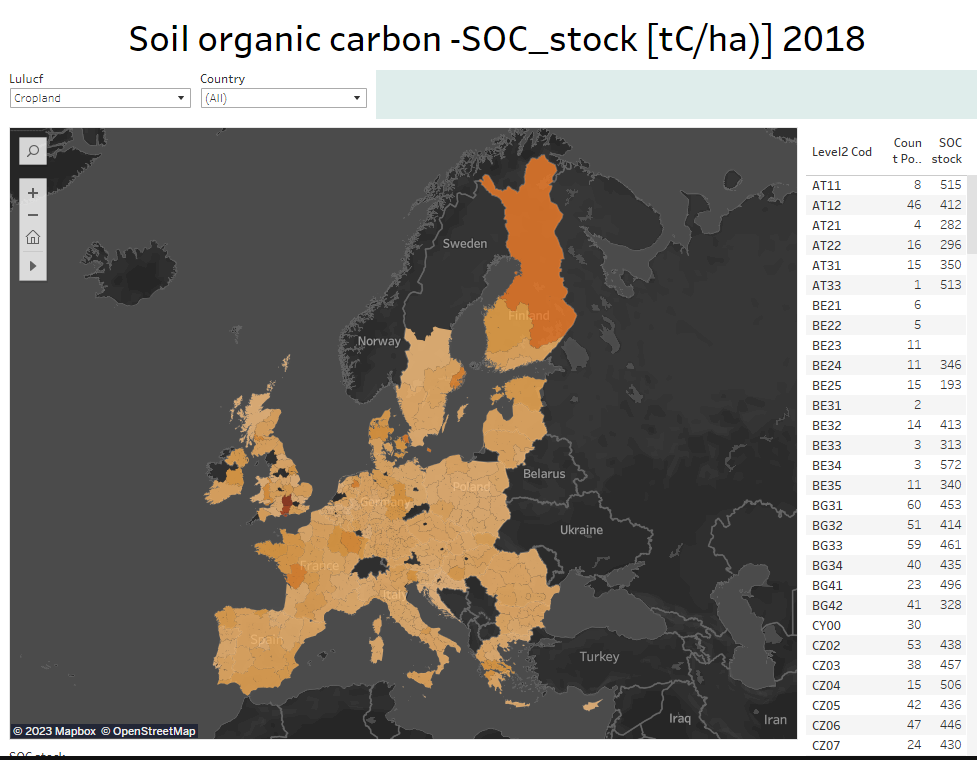

# Annex

LUCAS: Land Use and Coverage Area frame Survey
https://esdac.jrc.ec.europa.eu/projects/lucas
LUCAS: Land Use and Coverage Area frame Survey
Following a decision of the European Parliament, the European Statistical Office (EUROSTAT) in close cooperation with the Directorate General responsible for Agriculture and the technical support of the JRC, is organising regular, harmonised surveys across all Member States to gather information on land cover and land use. This survey is known as LUCAS (Land Use/Cover Area frame statistical Survey). The name reflects the methodology used to collect the information. Estimates of the area occupied by different land use or land cover types are computed on the basis of observations taken at more than 250,000 sample points throughout the EU rather than mapping the entire area under investigation. By repeating the survey every few years, changes to land use can be identified.

LUCAS 2009/2012
In 2009, the European Commission extended the periodic Land Use/Land Cover Area Frame Survey (LUCAS) to sample and analyse the main properties of topsoil in 23 Member States of the European Union (EU). This topsoil survey represents the first attempt to build a consistent spatial database of the soil cover across the EU based on standard sampling and analytical procedures, with the analysis of all soil samples being carried out in a single laboratory. Approximately 20,000 points were selected out of the main LUCAS grid for the collection of soil samples. A standardised sampling procedure was used to collect around 0.5 kg of topsoil (0-20 cm). The samples were dispatched to a central laboratory for physical and chemical analyses.

Subsequently, Malta and Cyprus provided soil samples even though the main LUCAS survey was not carried out on their territories. Cyprus has adapted the sampling methodology of LUCAS-Topsoil for (the southern part of the island) while Malta adjusted its national sampling grid to correspond to the LUCAS standards. Bulgaria and Romania have been sampled in 2012. However, the analysis is ongoing and the results are not included in this data collection. The final database contains 19,967 geo-referenced samples distributed in 25 countries. The data are freely available and can be downloaded after prior registration through the Request Form..

The report "LUCAS Topsoil Survey: methodology, data and results" provides a detailed insight to the design and methodology of the data collection and laboratory analysis.

All samples have been analysed for the percentage of coarse fragments, particle size distribution (% clay,silt and sand content), pH (in CaCl2 and H2O), organic carbon (g/kg), carbonate content (g/kg), phosphorous content (mg/kg), total nitrogen content (g/kg), extractable potassium content (mg/kg) , cation exchange capacity (cmol(+)/kg) and multispectral properties.

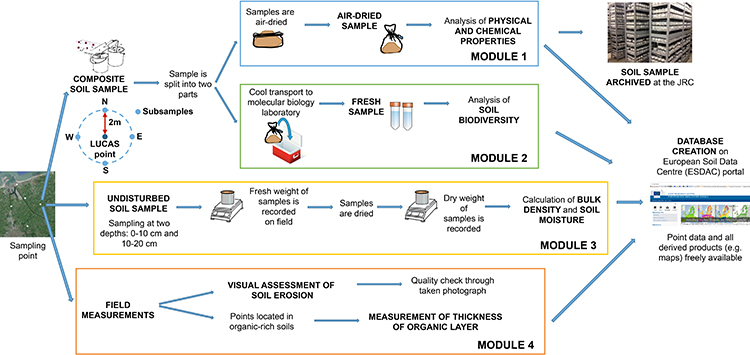
Fig. 1: LUCAS Soil workflow from sampling to database generation

While the LUCAS approach is designed for monitoring land use/land cover change, potential bias in the sampling design may not necessarily capture all soil characteristics in a country. Finally, a customised application has been developed for web browsers that allow users to view and query the LUCAS dataset in a variety of ways. 

LUCAS 2015
The LUCAS 2015 Soil Module targeted a revisit to 90% of the locations sampled in the 2009 survey and expanded to cover all 28 EU Member States (MS) and locations at altitudes above 1000 m. The remaining 10% of samples were reassigned to new locations within each MS. Approximately 22,000 samples have been analysed for pH, organic carbon, nutrient concentrations (N, P, K) and electrical conductivity (new in 2015) -  over 23 000  samples were analysed if countries outside the EU).  Particle size has was only measured for locations that were sampled for the first time in 2015 (otherwise see 2009 data for particle size). 

An additional 1,000 samples (approximately) were collected and analysed from Albania, Bosnia-Herzegovina, Croatia, North Macedonia, Montenegro, Serbia and Switzerland. Data for these countries will be uploaded in the coming months.

The principal products that will be available from this site will be:

Topsoil data from 2015 are available as CSV files. To facilitate use of the data, .XLS and ESRI shapefile formats are also available
A report describing the 2015 dataset for the EU and a report describing changes between 2009 and 2015.
Reference ancillary data describing a range of environmental conditions for the LUCAS Soil locations together with a supporting report
Topsoil microdata for individual countries
A report on data evaluation of laboratory data for soil organic carbon (Survey periods 2009, 2012 and 2015)
Multispectral reflectance data
X-Ray Diffraction data on a subset of 400 samples
Data from samples collected during 2015 in Switzerland using the same methodology are available from here.
Data from Albania, Bosnia and Herzegovina, North Maccedonia, Montenegro, Serbia collected during 2015 using the same methodology.
The data are freely available and can be downloaded after prior registration through the Request Form.

LUCAS 2018
In 2018, the LUCAS Soil survey will include the additional analyses (components 2, 3 and 4) for the first time: a) Bulk density (i.e. weight of dry soil in a given soil volume). b) Soil biodiversity c) Visual assessment of soil erosion and d) Measurement of the thickness of the organic horizon in organic-rich soil.

Soil biodiversity analysis: The most extensive EU assessment of soil biodiversity, based on DNA metabarcoding will be included as part of the LUCAS Soil survey. For this, 1000 points were selected. Analysis will target the following attributes: Bacteria and Archaea (16S rDNA), Fungi (ITS), Eukaryotes (18S rDNA), Microfauna (nematodes), Mesofauna (arthropods), Macrofauna (earthworms), Metagenomics.

Bulk density will be measured at 9000 points. Points were selected from the total set based on the heterogeneity of soil texture and organic carbon content, land use and land cover, topography and soil type. A CLHS approach was used to select candidate points, as for the biodiversity. Bulk density data points coincided with soil biodiversity points to explore possible correlation between these properties.

Visual assessment of erosion.Surveyors will provide a qualitative assessment of soil erosion by indicating the type of erosion (i.e. sheet, rill, gully, mass movement, re-deposition and wind erosion), and the distance and direction from the LUCAS point, together with an estimate of the number of rills or gullies observed.

Measurement of thickness of organic horizon in organic-rich soil. The thickness of the organic horizon in effectively or potentially organic-rich soil will be measured at 1470 locations.

The data are freely available and can be downloaded after prior registration through the Request Form.

LUCAS 2022
The purpose of this document, prepared by JRC and Eurostat, is to:

explain the underlying principles behind the LUCAS soil module,
describe its subsequent development driven by the policy needs of the Commission, research, and lately, also by some countries, and
present a proposal to adapt, adjust and improve the LUCAS Soil methodology for the 2022 Survey so that it serves the evolving policy needs of EC services, and beyond,
identify mechanisms for increased involvement with Member States.
Use of LUCAS topsoil database
The LUCAS 2009 topsoil database is available for download since September 2013. This database has extensively used for modelling purposes and the development or validation of ten datasets in European scale: Soil Organic carbon content in Europe, Multispectral reflectance data in EU soil, Soil erodibility (K-factor), Soil organic carbon (SOC) stocks, Soil water erosion, Physical properties, Threats to soil biodiversity in EU, wind erosion modelling, N2O emissions in EU and future SOC stocks.

The LUCAS topsoil dataset and the derived products have been downloaded more than 4,500 times from the European Soil Data Centre (ESDAC) during the period (Sep 2013 - Sep 2017). The LUCAS Soil dataset has a wide range of potential applications: a) Modelling of soil-related properties at the continental scale. b) Assessing the contribution of the soil component to regulation c) of large-scale environmental phenomena such as climate change and nutrient cycles. d) Validation of small-scale models involving soil properties e) Comparison and checking of the quality of national and regional soil inventories. f) Assessing the ecosystem services provided by soil g) Evaluation of the effect of soil on key economic activities such
as agriculture.

A post assessment survey of LUCAS data was conducted in order to evaluate the data utility, the scale and te publication outputs. Overall, statistics on LUCAS Soil download and use emphasize the value of such a resource. Continuous development of the LUCAS Soil database and derived datasets will ensure further growth of potentially interested users and thus their application in new fields of research.

LUCAS in Eurostat Website
    -Land cover/use (LUCAS) Data 2009 http://ec.europa.eu/eurostat/web/lucas/data/primary-data/2009
    -Land cover/use (LUCAS) Data 2012 http://ec.europa.eu/eurostat/web/lucas/data/primary-data/2012
    -Land cover/use (LUCAS) Data 2015 http://ec.europa.eu/eurostat/web/lucas/data/primary-data/2015
    -Land cover/use (LUCAS) Data 2018 http://ec.europa.eu/eurostat/web/lucas/data/primary-data/2018
    -Land cover/use LUCAS) Methodology http://ec.europa.eu/eurostat/web/lucas/methodology
    



